In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import re
import warnings
import joblib
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
df = pd.read_csv("BBC News Train.csv")
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())

Dataset loaded successfully!
Dataset shape: (1490, 3)
Columns: ['ArticleId', 'Text', 'Category']

First 5 rows of the dataset:
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

Missing values:
ArticleId    0
Text         0
Category     0
dtype: int64


In [4]:
# Dataset statistics
print("\n=== DATASET STATISTICS ===")
print(f"Unique categories: {df['Category'].unique()}")
print(f"Number of categories: {df['Category'].nunique()}")
print("\nCategory Distribution:")
category_counts = df['Category'].value_counts()
for category, count in category_counts.items():
    print(f"  {category}: {count} articles ({count/len(df)*100:.1f}%)")



=== DATASET STATISTICS ===
Unique categories: ['business' 'tech' 'politics' 'sport' 'entertainment']
Number of categories: 5

Category Distribution:
  sport: 346 articles (23.2%)
  business: 336 articles (22.6%)
  politics: 274 articles (18.4%)
  entertainment: 273 articles (18.3%)
  tech: 261 articles (17.5%)


In [5]:
# Text preprocessing
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    return text

print("\n=== TEXT PREPROCESSING ===")
df['processed_text'] = df['Text'].apply(preprocess_text)
df['text_length'] = df['processed_text'].str.len()
df['word_count'] = df['processed_text'].str.split().str.len()
print("Text Statistics:")
print(f"  Average text length: {df['text_length'].mean():.1f} characters")
print(f"  Average word count: {df['word_count'].mean():.1f} words")
print(f"  Max text length: {df['text_length'].max()} characters")
print(f"  Min text length: {df['text_length'].min()} characters")


=== TEXT PREPROCESSING ===
Text Statistics:
  Average text length: 2145.7 characters
  Average word count: 377.0 words
  Max text length: 17745 characters
  Min text length: 489 characters


In [6]:
# Encode categories
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['Category'])
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"\nCategory encoding mapping: {category_mapping}")

# Train-test split
print("\n=== TRAIN-TEST SPLIT ===")
X = df['processed_text']
y = df['category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Category encoding mapping: {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

=== TRAIN-TEST SPLIT ===
Training set size: 1192
Test set size: 298


In [7]:
# Feature extraction
print("\n=== FEATURE EXTRACTION ===")
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2), min_df=2, max_df=0.95)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")


=== FEATURE EXTRACTION ===
TF-IDF feature matrix shape: (1192, 10000)
Vocabulary size: 10000


In [8]:
# Model training and saving
print("\n=== MODEL TRAINING ===")
models = {}
results = {}

# Naive Bayes
print("\n1. Training Multinomial Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_preds = nb_model.predict(X_test_tfidf)
nb_acc = accuracy_score(y_test, nb_preds)
nb_f1 = f1_score(y_test, nb_preds, average='weighted')
models['Naive Bayes'] = nb_model
results['Naive Bayes'] = {'accuracy': nb_acc, 'f1_score': nb_f1}
print(f"Naive Bayes - Accuracy: {nb_acc:.4f}, F1 Score: {nb_f1:.4f}")

# SVM
print("\n2. Training Support Vector Machine...")
svm_model = SVC(kernel='linear', random_state=42, C=1.0, verbose=False)
svm_model.fit(X_train_tfidf, y_train)
svm_preds = svm_model.predict(X_test_tfidf)
svm_acc = accuracy_score(y_test, svm_preds)
svm_f1 = f1_score(y_test, svm_preds, average='weighted')
models['SVM'] = svm_model
results['SVM'] = {'accuracy': svm_acc, 'f1_score': svm_f1}
print(f"SVM - Accuracy: {svm_acc:.4f}, F1 Score: {svm_f1:.4f}")

# Random Forest
print("\n3. Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=20, verbose=0)
rf_model.fit(X_train_tfidf, y_train)
rf_preds = rf_model.predict(X_test_tfidf)
rf_acc = accuracy_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds, average='weighted')
models['Random Forest'] = rf_model
results['Random Forest'] = {'accuracy': rf_acc, 'f1_score': rf_f1}
print(f"Random Forest - Accuracy: {rf_acc:.4f}, F1 Score: {rf_f1:.4f}")

# Logistic Regression
print("\n4. Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000, C=1.0, verbose=0)
lr_model.fit(X_train_tfidf, y_train)
lr_preds = lr_model.predict(X_test_tfidf)
lr_acc = accuracy_score(y_test, lr_preds)
lr_f1 = f1_score(y_test, lr_preds, average='weighted')
models['Logistic Regression'] = lr_model
results['Logistic Regression'] = {'accuracy': lr_acc, 'f1_score': lr_f1}
print(f"Logistic Regression - Accuracy: {lr_acc:.4f}, F1 Score: {lr_f1:.4f}")



=== MODEL TRAINING ===

1. Training Multinomial Naive Bayes...
Naive Bayes - Accuracy: 0.9732, F1 Score: 0.9731

2. Training Support Vector Machine...
SVM - Accuracy: 0.9732, F1 Score: 0.9729

3. Training Random Forest...
Random Forest - Accuracy: 0.9497, F1 Score: 0.9496

4. Training Logistic Regression...
Logistic Regression - Accuracy: 0.9664, F1 Score: 0.9663


In [14]:
# Save models, vectorizer, and label encoder
print("\n=== SAVING MODELS ===")
joblib.dump(nb_model, 'naive_bayes_model.pkl')
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(lr_model, 'logistic_regression_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(results, 'model_results.pkl')
print("Models, vectorizer, and label encoder saved successfully!")


=== SAVING MODELS ===
Models, vectorizer, and label encoder saved successfully!


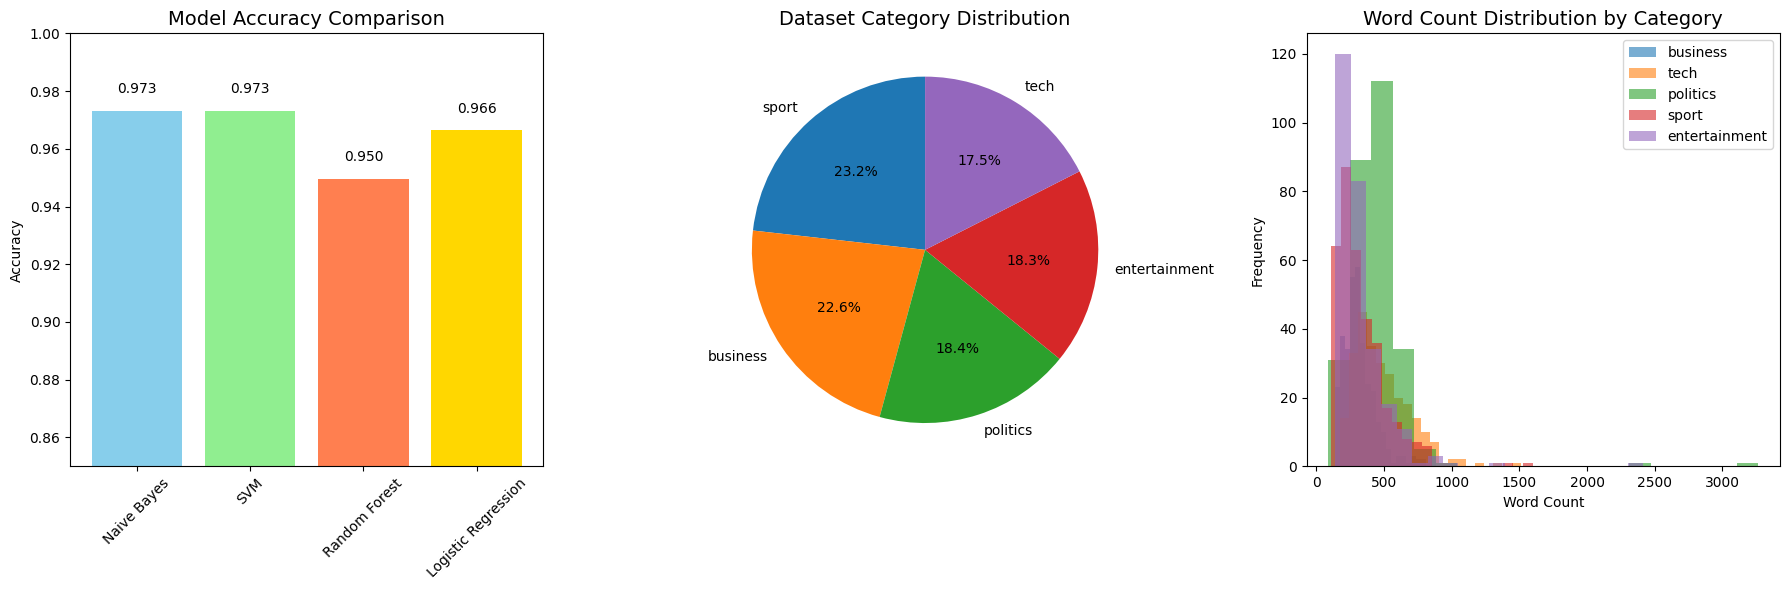

In [10]:
# Results summary (keeping original visualization and reporting code unchanged)
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
model_names = list(results.keys())
accuracies = [results[model]['accuracy'] for model in model_names]
colors = ['skyblue', 'lightgreen', 'coral', 'gold']
bars = plt.bar(model_names, accuracies, color=colors)
plt.title('Model Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0.85, 1.0)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{acc:.3f}', ha='center', va='bottom')

plt.subplot(1, 3, 2)
category_names = category_counts.index
counts = category_counts.values
plt.pie(counts, labels=category_names, autopct='%1.1f%%', startangle=90)
plt.title('Dataset Category Distribution', fontsize=14)

plt.subplot(1, 3, 3)
for category in df['Category'].unique():
    category_data = df[df['Category'] == category]['word_count']
    plt.hist(category_data, alpha=0.6, label=category, bins=20)
plt.title('Word Count Distribution by Category', fontsize=14)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
print("\n=== RESULTS SUMMARY ===")
print("+------+----------------------+------------+-----------+--------------+")
print("| S.No | Model                | Accuracy   | F1-Score  | Performance  |")
print("+------+----------------------+------------+-----------+--------------+")
for i, (model_name, metrics) in enumerate(results.items(), 1):
    acc = metrics['accuracy']
    f1 = metrics['f1_score']
    performance = "Excellent" if acc >= 0.95 else "Very Good" if acc >= 0.90 else "Good" if acc >= 0.85 else "Fair" if acc >= 0.80 else "Poor"
    print(f"| {i:<4} | {model_name:<20} | {acc:<10.4f} | {f1:<9.4f} | {performance:<12} |")
print("+------+----------------------+------------+-----------+--------------+")


=== RESULTS SUMMARY ===
+------+----------------------+------------+-----------+--------------+
| S.No | Model                | Accuracy   | F1-Score  | Performance  |
+------+----------------------+------------+-----------+--------------+
| 1    | Naive Bayes          | 0.9732     | 0.9731    | Excellent    |
| 2    | SVM                  | 0.9732     | 0.9729    | Excellent    |
| 3    | Random Forest        | 0.9497     | 0.9496    | Very Good    |
| 4    | Logistic Regression  | 0.9664     | 0.9663    | Excellent    |
+------+----------------------+------------+-----------+--------------+



Best performing model: Naive Bayes
Best accuracy: 0.9732

=== DETAILED CLASSIFICATION REPORT (Naive Bayes) ===
               precision    recall  f1-score   support

     business       0.94      0.99      0.96        67
entertainment       1.00      0.98      0.99        55
     politics       0.98      0.95      0.96        55
        sport       0.99      1.00      0.99        69
         tech       0.96      0.94      0.95        52

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298


=== CONFUSION MATRIX (Naive Bayes) ===


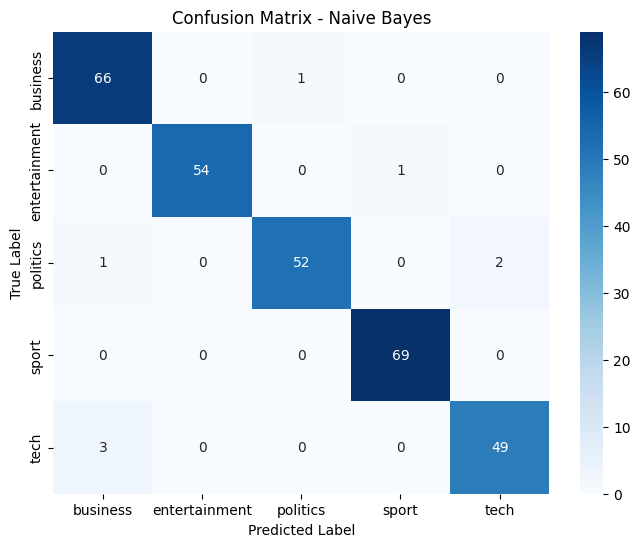

In [12]:
best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
best_model = models[best_model_name]
print(f"\nBest performing model: {best_model_name}")
print(f"Best accuracy: {results[best_model_name]['accuracy']:.4f}")

print(f"\n=== DETAILED CLASSIFICATION REPORT ({best_model_name}) ===")
best_preds = best_model.predict(X_test_tfidf)
target_names = label_encoder.classes_
print(classification_report(y_test, best_preds, target_names=target_names))

print(f"\n=== CONFUSION MATRIX ({best_model_name}) ===")
cm = confusion_matrix(y_test, best_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [13]:
print("\n=== SAMPLE PREDICTIONS ===")
print("+------+-----------------------------------------------------------------+------------------------------+")
print("| No.  | Sample Text                                                     | Predicted Category           |")
print("+------+-----------------------------------------------------------------+------------------------------+")
sample_texts = [
    "Tesla unveils groundbreaking electric car with record-breaking range!",
    "Local team wins national championship in a stunning upset victory!",
    "Government releases updated guidelines for workplace safety standards."
]
sample_processed = [preprocess_text(text) for text in sample_texts]
sample_tfidf = vectorizer.transform(sample_processed)
sample_preds = best_model.predict(sample_tfidf)
sample_categories = label_encoder.inverse_transform(sample_preds)
for i, (text, pred_category) in enumerate(zip(sample_texts, sample_categories), 1):
    preview = text[:60] + ("..." if len(text) > 60 else "")
    print(f"| {i:<4} | {preview:<60} | {pred_category:<28} |")
print("+------+-----------------------------------------------------------------+------------------------------+")


=== SAMPLE PREDICTIONS ===
+------+-----------------------------------------------------------------+------------------------------+
| No.  | Sample Text                                                     | Predicted Category           |
+------+-----------------------------------------------------------------+------------------------------+
| 1    | Tesla unveils groundbreaking electric car with record-breaki... | business                     |
| 2    | Local team wins national championship in a stunning upset vi... | sport                        |
| 3    | Government releases updated guidelines for workplace safety ... | politics                     |
+------+-----------------------------------------------------------------+------------------------------+
